# Доверительные интервалы для оценки среднего

In [38]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
import numpy as np

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [141]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

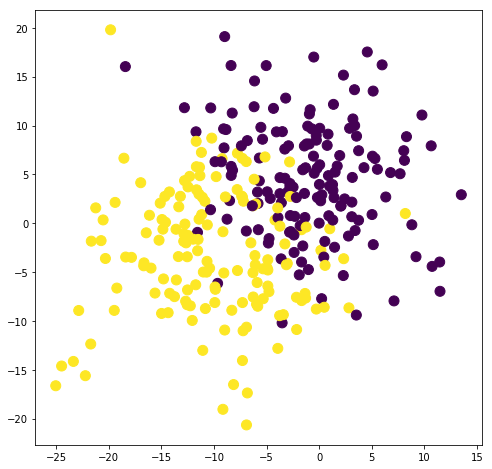

In [142]:
pylab.figure(figsize(8, 8))
pylab.scatter(list(map(lambda x: x[0], blobs[0])), list(map(lambda x: x[1], blobs[0])), c = blobs[1], s=100)

## Сравнение линейных моделей

### Точечная оценка

In [143]:
train_data, test_data, train_labels, test_labels = train_test_split(blobs[0], blobs[1], 
                                                                                test_size = 15,
                                                                                    random_state = 1)

In [144]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.8888888888888888

In [145]:
sgd_model = linear_model.SGDClassifier(random_state = 0)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

0.8888888888888888

### Оценка среднего

In [146]:
sgd_auc_scores = cross_val_score(linear_model.SGDClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

In [147]:
ridge_auc_scores = cross_val_score(linear_model.RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

### Точечная оценка среднего

In [148]:
print("sgd model auc: mean {}, std {}".format(sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))
print("ridge model auc: mean {}, std {}".format(ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))

sgd model auc: mean 0.8761160714285714, std 0.1507335690843397
ridge model auc: mean 0.9479910714285713, std 0.05365806084995355


### Интервальная оценка среднего 

In [149]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [150]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [153]:
print("sgd model mean auc 95% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print("ridge model mean auc 95% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided'))

sgd model mean auc 95% confidence interval (0.6569854362844261, 1.0952467065727167)
ridge model mean auc 95% confidence interval (0.728860436284426, 1.1671217065727166)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [152]:
type(sgd_auc_scores)

numpy.ndarray

In [155]:
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

In [156]:
print("sgd model mean auc 95% confidence interval", _tconfint_generic(sgd_mean, sgd_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided'))

print("ridge model mean auc 95% confidence interval", _tconfint_generic(ridge_mean, ridge_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided'))

sgd model mean auc 95% confidence interval (0.8055705895660097, 0.9466615532911331)
ridge model mean auc 95% confidence interval (0.9228783259302369, 0.9731038169269057)


# Задание

Для 61 большого города в Англии и Уэльсе известны средняя годовая смертность на 100000 населения (по данным 1958–1964) и концентрация кальция в питьевой воде (в частях на миллион). Чем выше концентрация кальция, тем жёстче вода. Города дополнительно поделены на северные и южные.

Постройте 95% доверительный интервал для средней годовой смертности в больших городах. Чему равна его нижняя граница? Округлите ответ до 4 знаков после десятичной точки.

In [158]:
import pandas as pd  

In [159]:
df = pd.read_table('water.txt', sep='\\t')

In [160]:
df.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


In [164]:
df['mortality'].describe()

count      61.000000
mean     1524.147541
std       187.668754
min      1096.000000
25%      1379.000000
50%      1555.000000
75%      1668.000000
max      1987.000000
Name: mortality, dtype: float64

In [169]:
std_water = df['mortality'].std(ddof = 1)/sqrt(len(df))
mean_water = df['mortality'].mean()

In [170]:
print("95% confidence interval for mean", _tconfint_generic(mean_water, std_water,
                                                                       len(df) - 1,
                                                                       0.05, 'two-sided'))

95% confidence interval for mean (1476.0833413552848, 1572.2117406119285)


In [193]:
south_cnt = df[df['location'] == 'South']['location'].count()
south_mean = df.groupby('location')['mortality'].mean()[1]
south_std = df.groupby('location')['mortality'].std(ddof=1)[1]/sqrt(south_cnt)


In [194]:
print("95% confidence interval for mean in south cities", _tconfint_generic(south_mean, south_std,
                                                                       south_cnt - 1,
                                                                       0.05, 'two-sided'))

95% confidence interval for mean in south cities (1320.1517462936238, 1433.463638321761)


In [204]:
north_cnt = df[df['location'] == 'North']['location'].count()
north_mean = df.groupby('location')['mortality'].mean()[0]
north_std = df.groupby('location')['mortality'].std(ddof=1)[0]/sqrt(south_cnt)

In [205]:
print("95% confidence interval for mean in North cities", _tconfint_generic(north_mean, north_std,
                                                                       north_cnt - 1,
                                                                       0.05, 'two-sided'))

95% confidence interval for mean in North cities (1579.0229807999567, 1688.177019200043)


In [207]:
south_cnt_water = df[df['location'] == 'South']['location'].count()
south_mean_water = df.groupby('location')['hardness'].mean()[1]
south_std_water = df.groupby('location')['hardness'].std(ddof=1)[1]/sqrt(south_cnt_water)

In [208]:
print("95% confidence interval for mean in South cities", _tconfint_generic(south_mean_water, south_std_water,
                                                                       south_cnt_water - 1,
                                                                       0.05, 'two-sided'))

95% confidence interval for mean in South cities (53.4671986920361, 86.07126284642544)


In [209]:
north_cnt_water = df[df['location'] == 'North']['location'].count()
north_mean_water = df.groupby('location')['hardness'].mean()[0]
north_std_water = df.groupby('location')['hardness'].std(ddof=1)[0]/sqrt(north_cnt_water)

In [210]:
print("95% confidence interval for mean in North cities", _tconfint_generic(north_mean_water, north_std_water,
                                                                       north_cnt_water - 1,
                                                                       0.05, 'two-sided'))

95% confidence interval for mean in North cities (21.422487285724255, 39.37751271427574)


In [297]:
sgd_mean = 0
n = 200

In [298]:
print("test samples count at 95% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(1/n), 
                                                                  0.10, 'two-sided'))

test samples count at 95% confidence interval (-0.11630871536766738, 0.11630871536766738)
